In [101]:
import os
import numpy as np
import pandas as pd
from pylab import plt, mpl

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
pd.set_option('display.precision', 4)
np.set_printoptions(suppress=True, precision=4)
os.environ['PYTHONHASHSEED'] = '0'

url = 'https://hilpisch.com/aiif_eikon_eod_data.csv'
data = pd.read_csv(url, index_col=0, parse_dates=True).dropna()

<Axes: xlabel='Date'>

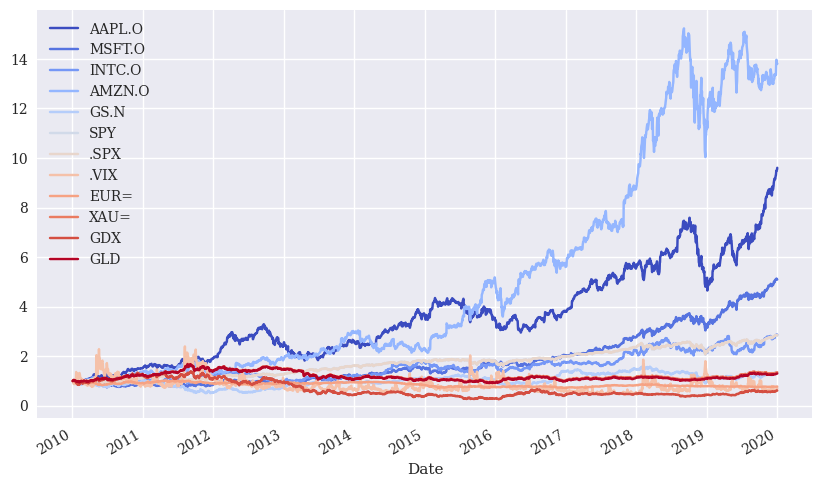

In [9]:
(data / data.iloc[0]).plot(figsize=(10,6), cmap= 'coolwarm')

In [11]:
lags = 7

def add_lags(data, ric, lags):
    cols = []
    df = pd.DataFrame(data[ric])

    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)
        df[col] = df[ric].shift(lag)
        cols.append(col)
    df.dropna(inplace=True)
    return df, cols

dfs = {}

for sym in data.columns:
    df, cols = add_lags(data, sym, lags)
    dfs[sym] = df

dfs[sym].head(7)

,GLD,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
Date,,,,,,,,
2010-01-13,111.54,110.49,112.85,111.37,110.82,111.51,109.70,109.80
2010-01-14,112.03,111.54,110.49,112.85,111.37,110.82,111.51,109.70
2010-01-15,110.86,112.03,111.54,110.49,112.85,111.37,110.82,111.51
2010-01-19,111.52,110.86,112.03,111.54,110.49,112.85,111.37,110.82
2010-01-20,108.94,111.52,110.86,112.03,111.54,110.49,112.85,111.37
2010-01-21,107.37,108.94,111.52,110.86,112.03,111.54,110.49,112.85
2010-01-22,107.17,107.37,108.94,111.52,110.86,112.03,111.54,110.49


In [13]:
regs = {}
for sym in data.columns:
    df = dfs[sym]
    reg = np.linalg.lstsq(df[cols], df[sym], rcond=-1)[0]
    regs[sym] = reg

rega = np.stack(tuple(regs.values()))
regd  = pd.DataFrame(rega, columns=cols, index=data.columns)

regd

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
AAPL.O,1.0106,-0.0592,0.0258,0.0535,-0.0172,0.0060,-0.0184
MSFT.O,0.8928,0.0112,0.1175,-0.0832,-0.0258,0.0567,0.0323
INTC.O,0.9519,0.0579,0.0490,-0.0772,-0.0373,0.0449,0.0112
AMZN.O,0.9799,-0.0134,0.0206,0.0007,0.0525,-0.0452,0.0056
GS.N,0.9806,0.0342,-0.0172,0.0042,-0.0387,0.0585,-0.0215
SPY,0.9692,0.0067,0.0228,-0.0244,-0.0237,0.0379,0.0121
.SPX,0.9672,0.0106,0.0219,-0.0252,-0.0318,0.0515,0.0063
.VIX,0.8823,0.0591,-0.0289,0.0284,-0.0256,0.0511,0.0306
EUR=,0.9859,0.0239,-0.0484,0.0508,-0.0217,0.0149,-0.0055
XAU=,0.9864,0.0069,0.0166,-0.0215,0.0044,0.0198,-0.0125


<Axes: >

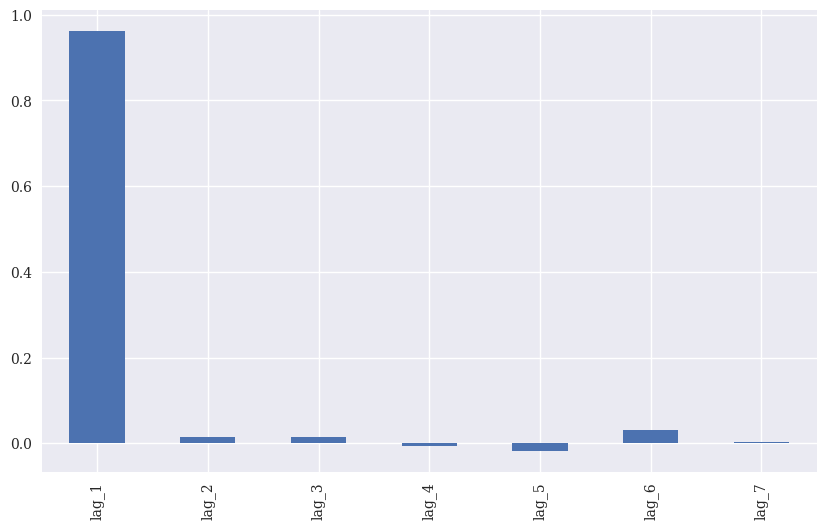

In [14]:
regd.mean().plot(kind='bar', figsize=(10,6))

In [15]:
dfs[sym].corr()

,GLD,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
GLD,1.0000,0.9972,0.9946,0.9920,0.9893,0.9867,0.9841,0.9815
lag_1,0.9972,1.0000,0.9972,0.9946,0.9920,0.9893,0.9867,0.9842
lag_2,0.9946,0.9972,1.0000,0.9972,0.9946,0.9920,0.9893,0.9867
lag_3,0.9920,0.9946,0.9972,1.0000,0.9972,0.9946,0.9920,0.9893
lag_4,0.9893,0.9920,0.9946,0.9972,1.0000,0.9972,0.9946,0.9920
lag_5,0.9867,0.9893,0.9920,0.9946,0.9972,1.0000,0.9972,0.9946
lag_6,0.9841,0.9867,0.9893,0.9920,0.9946,0.9972,1.0000,0.9972
lag_7,0.9815,0.9842,0.9867,0.9893,0.9920,0.9946,0.9972,1.0000


In [18]:
from statsmodels.tsa.stattools import adfuller

In [19]:
adfuller(data[sym].dropna())

(-1.9488969577009956,
 0.3094193074034716,
 0,
 2515,
 {'1%': -3.4329527780962255,
  '5%': -2.8626898965523724,
  '10%': -2.567382133955709},
 8446.683102944744)

In [45]:
rets = np.log(data / data.shift(1))
rets.dropna(inplace=True)

dfs = {}

for sym in data:
    df, cols = add_lags(rets, sym, lags)    
    mu, std = df[cols].mean(), df[cols].std()
    df[cols] = (df[cols] - mu) / std    
    dfs[sym] = df

adfuller(dfs[sym]['lag_1'])
dfs[sym].corr()

,GLD,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
GLD,1.0000,-0.0297,0.0003,1.2635e-02,-0.0026,-5.9392e-03,0.0099,-0.0013
lag_1,-0.0297,1.0000,-0.0305,8.1418e-04,0.0128,-2.8765e-03,-0.0053,0.0098
lag_2,0.0003,-0.0305,1.0000,-3.1617e-02,0.0003,1.3234e-02,-0.0043,-0.0052
lag_3,0.0126,0.0008,-0.0316,1.0000e+00,-0.0313,-6.8542e-06,0.0141,-0.0044
lag_4,-0.0026,0.0128,0.0003,-3.1329e-02,1.0000,-3.1761e-02,0.0002,0.0141
lag_5,-0.0059,-0.0029,0.0132,-6.8542e-06,-0.0318,1.0000e+00,-0.0323,0.0002
lag_6,0.0099,-0.0053,-0.0043,1.4115e-02,0.0002,-3.2289e-02,1.0000,-0.0324
lag_7,-0.0013,0.0098,-0.0052,-4.3869e-03,0.0141,2.1707e-04,-0.0324,1.0000


In [52]:
from sklearn.metrics import accuracy_score

%time
for sym in data:
    df = dfs[sym]
    reg = np.linalg.lstsq(df[cols], df[sym], rcond=-1)[0]
    pred = np.dot(df[cols], reg)
    acc = accuracy_score(np.sign(df[sym]), np.sign(pred))
    print(f'OLS | {sym:10s} | acc= {acc:.4f}')

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 7.87 µs
OLS | AAPL.O     | acc= 0.5056
OLS | MSFT.O     | acc= 0.5088
OLS | INTC.O     | acc= 0.5040
OLS | AMZN.O     | acc= 0.5048
OLS | GS.N       | acc= 0.5080
OLS | SPY        | acc= 0.5080
OLS | .SPX       | acc= 0.5167
OLS | .VIX       | acc= 0.5291
OLS | EUR=       | acc= 0.4984
OLS | XAU=       | acc= 0.5207
OLS | GDX        | acc= 0.5307
OLS | GLD        | acc= 0.5072


In [53]:
from sklearn.neural_network import MLPRegressor

%time
for sym in data.columns:
    df = dfs[sym]
    model = MLPRegressor(
        hidden_layer_sizes=[512],
        random_state=100,
        max_iter=1000,
        early_stopping=True,
        validation_fraction=0.15,
        shuffle=False)
    model.fit(df[cols], df[sym])
    pred = model.predict(df[cols])
    acc = accuracy_score(np.sign(df[sym]), np.sign(pred))
    print(f'MLP | {sym:10s} | acc= {acc:.4f}') 

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 10.7 µs
MLP | AAPL.O     | acc= 0.6005
MLP | MSFT.O     | acc= 0.5853
MLP | INTC.O     | acc= 0.5766
MLP | AMZN.O     | acc= 0.5510
MLP | GS.N       | acc= 0.6527
MLP | SPY        | acc= 0.5419
MLP | .SPX       | acc= 0.5399
MLP | .VIX       | acc= 0.6579
MLP | EUR=       | acc= 0.5642
MLP | XAU=       | acc= 0.5522
MLP | GDX        | acc= 0.6029
MLP | GLD        | acc= 0.5259


In [64]:
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential


np.random.seed(100)
tf.random.set_seed(100)

def create_model(problem='regression'):
    model = Sequential()
    model.add(Dense(512, input_dim=len(cols), activation='relu'))
    if problem == 'regression':
        model.add(Dense(1, activation='linear'))
        model.compile(loss='mse', optimizer='adam')
    else:
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam')
    return model 

%time
for sym in data.columns[:]:
    df = dfs[sym]
    model = create_model()
    model.fit(df[cols], df[sym], epochs=25, verbose=False)
    pred = model.predict(df[cols])
    acc = accuracy_score(np.sign(df[sym]), np.sign(pred))
    print(f'DNN | {sym:10s} | acc= {acc:.4f}')

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 5.72 µs
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step
DNN | AAPL.O     | acc= 0.5128
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step
DNN | MSFT.O     | acc= 0.6328
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step
DNN | INTC.O     | acc= 0.5251
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step
DNN | AMZN.O     | acc= 0.4912
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step
DNN | GS.N       | acc= 0.5905
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step
DNN | SPY        | acc= 0.5933
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step
DNN | .SPX       | acc= 0.5670
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step
DNN | .VIX       | acc= 0.6192
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step
DNN | EUR=       | acc= 0.5375
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step
DNN | XAU=       | acc= 0.5610
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step
DNN | GDX        | acc= 0.5965
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step
DNN | GLD        | acc= 0.6124


In [76]:
split = int(len(dfs[sym]) * 0.8)

%time
for sym in data.columns:
    df = dfs[sym]
    train  = df.iloc[:split]
    reg = np.linalg.lstsq(train[cols], train[sym], rcond=-1)[0]
    test  = df.iloc[split:]
    pred = np.dot(test[cols], reg)    
    acc = accuracy_score(np.sign(test[sym]), np.sign(pred))
    print(f'OLS | {sym:10s} | acc= {acc:.4f}')

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 7.87 µs
OLS | AAPL.O     | acc= 0.5219
OLS | MSFT.O     | acc= 0.4960
OLS | INTC.O     | acc= 0.5418
OLS | AMZN.O     | acc= 0.4841
OLS | GS.N       | acc= 0.4980
OLS | SPY        | acc= 0.5020
OLS | .SPX       | acc= 0.5120
OLS | .VIX       | acc= 0.5458
OLS | EUR=       | acc= 0.4482
OLS | XAU=       | acc= 0.5299
OLS | GDX        | acc= 0.5159
OLS | GLD        | acc= 0.5100


In [3]:
url = 'https://hilpisch.com/aiif_eikon_id_eur_usd.csv'
symbol = 'EUR_USD'

raw = pd.read_csv(url, index_col=0, parse_dates=True)
raw.head()

,HIGH,LOW,OPEN,CLOSE
Date,,,,
2019-10-01 00:00:00,1.0899,1.0897,1.0897,1.0899
2019-10-01 00:01:00,1.0899,1.0896,1.0899,1.0898
2019-10-01 00:02:00,1.0898,1.0896,1.0898,1.0896
2019-10-01 00:03:00,1.0898,1.0896,1.0897,1.0898
2019-10-01 00:04:00,1.0898,1.0896,1.0897,1.0898


In [4]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96526 entries, 2019-10-01 00:00:00 to 2019-12-31 23:06:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HIGH    96526 non-null  float64
 1   LOW     96526 non-null  float64
 2   OPEN    96526 non-null  float64
 3   CLOSE   96526 non-null  float64
dtypes: float64(4)
memory usage: 3.7 MB


In [20]:
data = pd.DataFrame(raw['CLOSE'].loc[:])
data.columns = [symbol]

data = data.resample('1h', label='right').last().ffill()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2208 entries, 2019-10-01 01:00:00 to 2020-01-01 00:00:00
Freq: H
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   EUR_USD  2208 non-null   float64
dtypes: float64(1)
memory usage: 34.5 KB


<Axes: xlabel='Date'>

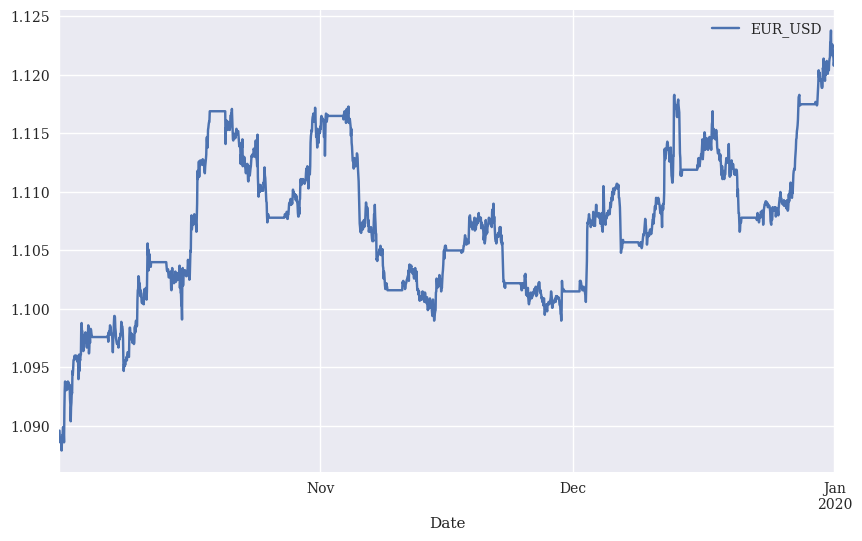

In [21]:
data.plot(figsize=(10,6))

In [22]:
lags = 5

def add_lags(data, symbol, lags, window=20):
    cols = []
    df = data.copy()
    df.dropna(inplace=True)
    df['r'] = np.log(df / df.shift())
    df['sma'] = df[symbol].rolling(window).mean()
    df['min'] = df[symbol].rolling(window).min()
    df['max'] = df[symbol].rolling(window).max()
    df['mom'] = df['r'].rolling(window).mean()
    df['vol'] = df['r'].rolling(window).std()
    df.dropna(inplace=True)

    df['d'] = np.where(df['r'] > 0, 1 , 0)
    features = [symbol, 'r', 'd', 'sma', 'min', 'max', 'mom', 'vol']
    for f in features:
        for lag in range(1, lags +1):
            col = f'{f}_lag_{lag}'
            df[col] = df[f].shift(lag)
            cols.append(col)
    df.dropna(inplace=True)
    return df, cols
            
        
data, cols = add_lags(data, symbol, lags)

In [23]:
c = data['d'].value_counts()
c

d
0    1445
1     738
Name: count, dtype: int64

In [24]:
def cw(df):
    c0, c1 = np.bincount(df['d'])
    w0 = (1 / c0 ) * (len(df)) / 2
    w1 = (1 / c1 ) * (len(df)) / 2
    return {0: w0, 1:w1}

In [26]:
class_weigth =  cw(data)
class_weigth

{0: 0.755363321799308, 1: 1.4789972899728998}

In [28]:
class_weigth[1] * c[1]

1091.5

In [77]:
import random
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score


def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

optimizer = Adam(learning_rate=0.001)

def create_model(hl=1, hu=128, optimizer=optimizer):
    model = Sequential()
    model.add(Dense(hu, input_dim=len(cols), activation='relu'))

    for _ in range(hl):
        model.add(Dense(hu, activation='relu'))            
        
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

set_seeds()
model =  create_model(hl=1, hu=128)

%time
model.fit(data[cols], data['d'], epochs=50, verbose=False, class_weight=cw(data))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs


In [40]:
model.evaluate(data[cols], data['d'])

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - accuracy: 0.5747 - loss: 0.5958


[0.5935877561569214, 0.584516704082489]

In [78]:
split = int(len(data) * 0.8)

train = data.iloc[:split].copy()
test = data.iloc[split:].copy()
optimizer = Adam(learning_rate=0.001)
set_seeds()
model =  create_model(hl=1, hu=128, optimizer=optimizer)

%time
model.fit(train[cols], train['d'], epochs=50, verbose=False, validation_split=0.2, shuffle=False, class_weight=cw(train))


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs


In [79]:
model.evaluate(train[cols], train['d'])

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - accuracy: 0.5714 - loss: 0.6253


[0.6287631988525391, 0.5756013989448547]

In [80]:
model.evaluate(test[cols], test['d'])

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.6189 - loss: 0.5762


[0.6118236184120178, 0.5949656963348389]

In [81]:
test['p'] = np.where(model.predict(test[cols]) > 0.5, 1, 0 )
test['p'].value_counts()

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


p
1    302
0    135
Name: count, dtype: int64

In [88]:
# res = pd.DataFrame(model.history.history)
# res[['accuracy', 'val_accuracy']].plot(figsize=(10,6), style='--')
model.history.history

{}

In [93]:
mu, std = train.mean(), train.std()

train_ = (train - mu) / std

optimizer = Adam(learning_rate=0.001)
set_seeds()
model =  create_model(hl=2, hu=128, optimizer=optimizer)

%time
model.fit(train[cols], train['d'], epochs=50, verbose=False, validation_split=0.2, shuffle=False, class_weight=cw(train))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.53 µs


In [94]:
model.evaluate(train_[cols], train['d'])

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - accuracy: 0.5573 - loss: 0.6520


[0.6695044636726379, 0.5595647096633911]

In [95]:
test_ = (test - mu) / std
model.evaluate(test_[cols], test['d'])

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.5565 - loss: 0.6871


[0.7210519909858704, 0.5720824003219604]

In [96]:
test['p'] = np.where(model.predict(test_[cols]) > 0.5, 1, 0 )
test['p'].value_counts()


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


p
0    237
1    200
Name: count, dtype: int64

In [97]:
from keras.layers import Dropout

def create_model(hl=1, hu=128, dropout=True, rate=0.3, optimizer=optimizer):
    model = Sequential()
    model.add(Dense(hu, input_dim=len(cols), activation='relu'))

    if dropout:
        model.add(Dense(1, activation='sigmoid'))

    for _ in range(hl):
        model.add(Dense(hu, activation='relu'))
        if dropout:
            model.add(Dropout(rate, seed=100))
        
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [98]:
optimizer = Adam(learning_rate=0.001)
set_seeds()
model =  create_model(hl=1, hu=128, rate=0.3, optimizer=optimizer)

%time
model.fit(train_[cols], train['d'], epochs=50, verbose=False, validation_split=0.15, shuffle=False, class_weight=cw(train))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [99]:
model.evaluate(train_[cols], train['d'])

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - accuracy: 0.7606 - loss: 0.4956


[0.547490119934082, 0.7182130813598633]

In [100]:
model.evaluate(test_[cols], test['d'])

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - accuracy: 0.6305 - loss: 0.6040


[0.6257659196853638, 0.6292906403541565]

<Axes: xlabel='Date'>

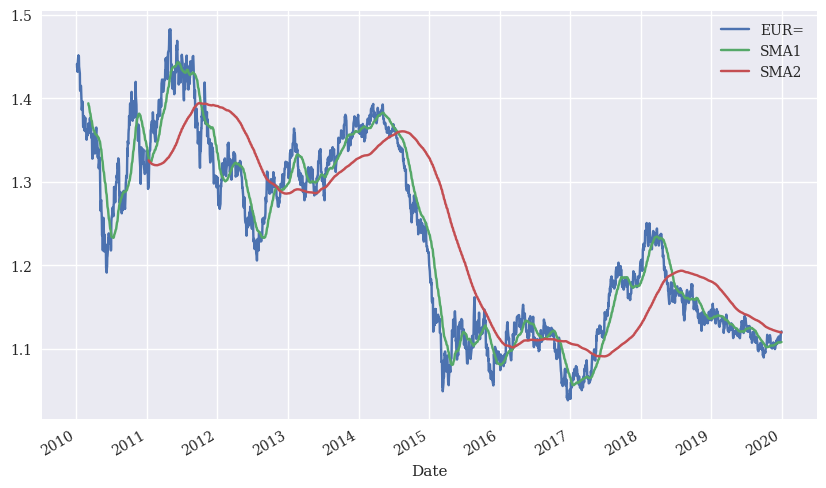

In [119]:
symbol = 'EUR='

url = 'https://hilpisch.com/aiif_eikon_eod_data.csv'
data = pd.DataFrame(pd.read_csv(url, index_col=0, parse_dates=True).dropna()[symbol])

data['SMA1'] = data[symbol].rolling(42).mean()
data['SMA2'] = data[symbol].rolling(258).mean()

data.plot(figsize=(10,6))

<Axes: xlabel='Date'>

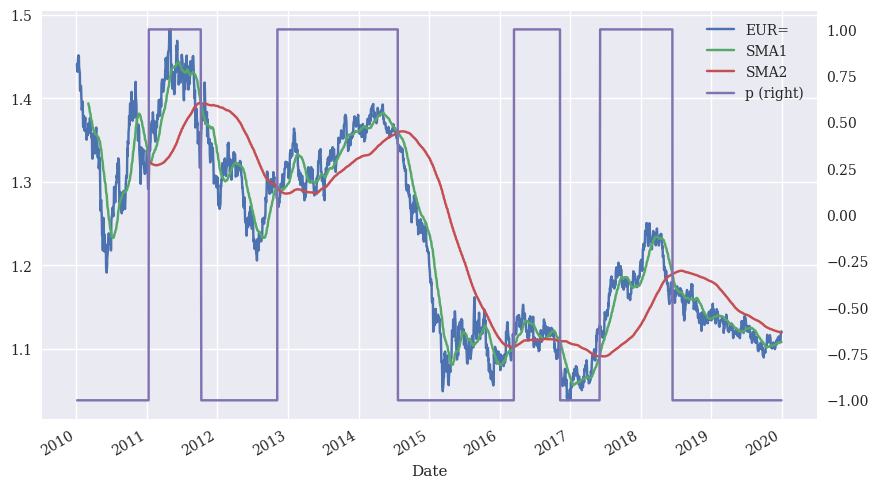

In [120]:
data['p'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
data['p'] = data['p'].shift(1)
data.plot(figsize=(10,6), secondary_y='p')

<Axes: xlabel='Date'>

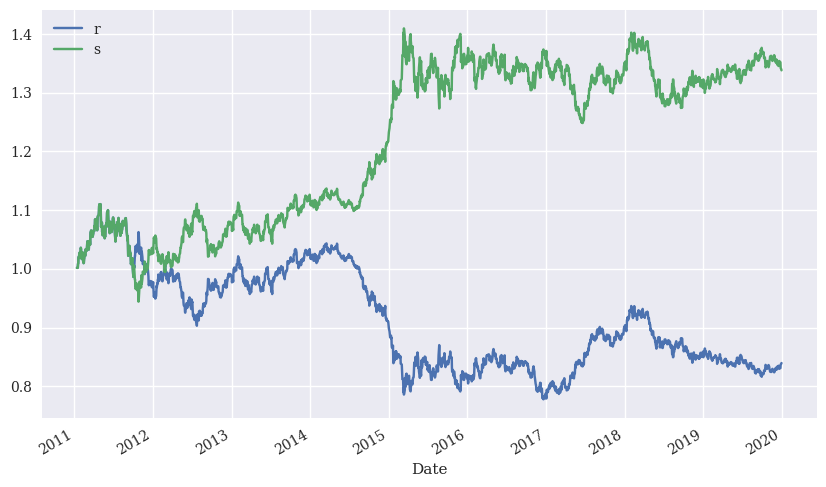

In [129]:
data['r'] = np.log(data[symbol]/data[symbol].shift(1))
data.dropna(inplace=True)

data['s'] = data['p'] * data['r']

data[['r', 's']].sum().apply(np.exp)

data[['r', 's']].sum().apply(np.exp) -1

data[['r', 's']].cumsum().apply(np.exp).plot(figsize=(10,6))

In [135]:
sum(data['p'].diff() != 0)+2

pc = 0.005

data['s_'] = np.where(data['p'].diff() != 0, data['s'] - pc, data['s'])

data['s_'].iloc[0] -= pc
data['s_'].iloc[-1] -= pc
data[['r', 's', 's_']][data['p'].diff() != 0 ]

,r,s,s_
Date,,,
2011-01-14,1.5713e-03,1.5713e-03,-0.0084
2011-10-10,1.9766e-02,-1.9766e-02,-0.0248
2012-11-07,-3.3616e-03,-3.3616e-03,-0.0084
2014-07-24,-7.4275e-05,7.4275e-05,-0.0049
2016-03-16,1.0211e-02,1.0211e-02,0.0052
2016-11-10,-1.8350e-03,1.8350e-03,-0.0032
2017-06-05,-2.4854e-03,-2.4854e-03,-0.0075
2018-06-15,3.4521e-03,-3.4521e-03,-0.0085


In [136]:
data[['r', 's', 's_']].sum().apply(np.exp)

r     0.8394
s     1.3383
s_    1.2730
dtype: float64

In [137]:
data[['r', 's', 's_']].sum().apply(np.exp) -1

r    -0.1606
s     0.3383
s_    0.2730
dtype: float64

<Axes: xlabel='Date'>

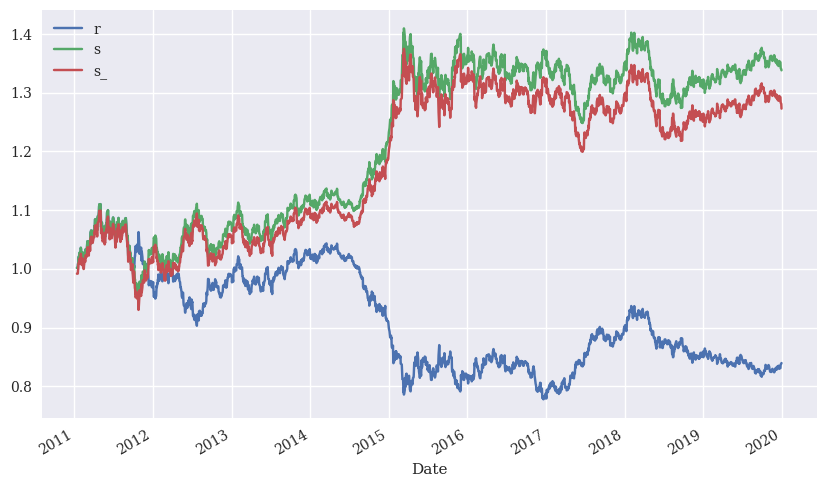

In [138]:
data[['r', 's', 's_']].cumsum().apply(np.exp).plot(figsize=(10,6))